In [2]:
# =============================================================
# 📦 Cell 1 – Import Required Libraries
# =============================================================
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, load_img, img_to_array
)
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os, random

# (Optional) reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


2025-06-15 12:50:12.769490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749991812.966597      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749991813.024551      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# =============================================================
# 📂 Cell 2 – Paths, Hyper‑parameters, Data Generators
# =============================================================
base_dir   = '/kaggle/input/maize-leaf-dataset/split_dataset'  # update if needed
img_size   = (224, 224)
batch_size = 32
epochs     = 20

train_datagen    = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size, batch_size=batch_size, class_mode='categorical')

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=img_size, batch_size=batch_size, class_mode='categorical')

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 4141 images belonging to 4 classes.
Found 516 images belonging to 4 classes.
Found 522 images belonging to 4 classes.


In [4]:
# =============================================================
# 🖼️ Cell 3 –Visualise Random Images
# =============================================================
def show_random_images_from_folder(folder_path, num_images=4):
    class_names = [c for c in os.listdir(folder_path)
                   if os.path.isdir(os.path.join(folder_path, c))]
    plt.figure(figsize=(15,5))
    for i in range(num_images):
        cls = random.choice(class_names)
        img_name = random.choice(os.listdir(os.path.join(folder_path, cls)))
        img_path = os.path.join(folder_path, cls, img_name)
        img = load_img(img_path, target_size=img_size)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img); plt.axis('off'); plt.title(cls)
    plt.tight_layout(); plt.show()

# Uncomment to preview samples
# show_random_images_from_folder(os.path.join(base_dir, 'train'))


In [5]:
# =============================================================
# 🧠 Cell 4 – Build AlexNet Model
# =============================================================
alexnet = models.Sequential([
    layers.Conv2D(96, (11,11), strides=4, activation='relu',
                  input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((3,3), strides=2),

    layers.Conv2D(256, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((3,3), strides=2),

    layers.Conv2D(384, (3,3), padding='same', activation='relu'),
    layers.Conv2D(384, (3,3), padding='same', activation='relu'),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((3,3), strides=2),

    layers.Flatten(),
    layers.Dense(4096, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dropout(0.5),

    layers.Dense(train_gen.num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749991833.012351      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 54, 54, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 26, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      26,218,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │          16,388 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,764,804 (178.39 MB)

 Trainable params: 46,764,100 (178.39 MB)

 Non-trainable params: 704 (2.75 KB)

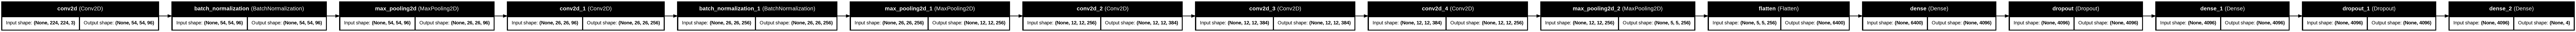

In [6]:
# =============================================================
# ⚙️ Cell 5 – Compile & Summary
# =============================================================
alexnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

alexnet.summary()

# Save horizontal architecture diagram (optional)
plot_model(alexnet, to_file='alexnet_architecture.png',
           show_shapes=True, show_layer_names=True, rankdir='LR')


In [7]:
# =============================================================
# 🚂 Cell 6 – Train the Model
# =============================================================
history = alexnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1749991840.147133     114 service.cc:148] XLA service 0x7eef48006ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749991840.148047     114 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749991840.661925     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/130 ━━━━━━━━━━━━━━━━━━━━ 24:20 11s/step - accuracy: 0.1875 - loss: 6.5898

I0000 00:00:1749991846.811769     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.6384 - loss: 5.1975 - val_accuracy: 0.2364 - val_loss: 5.5234
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.8343 - loss: 4.1238 - val_accuracy: 0.2267 - val_loss: 7.6804
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.8778 - loss: 3.6535 - val_accuracy: 0.4322 - val_loss: 5.2199
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.8988 - loss: 3.3033 - val_accuracy: 0.8798 - val_loss: 3.1698
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.9005 - loss: 3.0024 - val_accuracy: 0.8391 - val_loss: 2.9898
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.9354 - loss: 2.6945 - val_accuracy: 0.8275 - val_loss: 2.7139
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.9156 - loss: 2.5022 - val_accuracy: 0.8430 - val_loss: 2.5022
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.9498 - loss: 2.1987 - val_accu

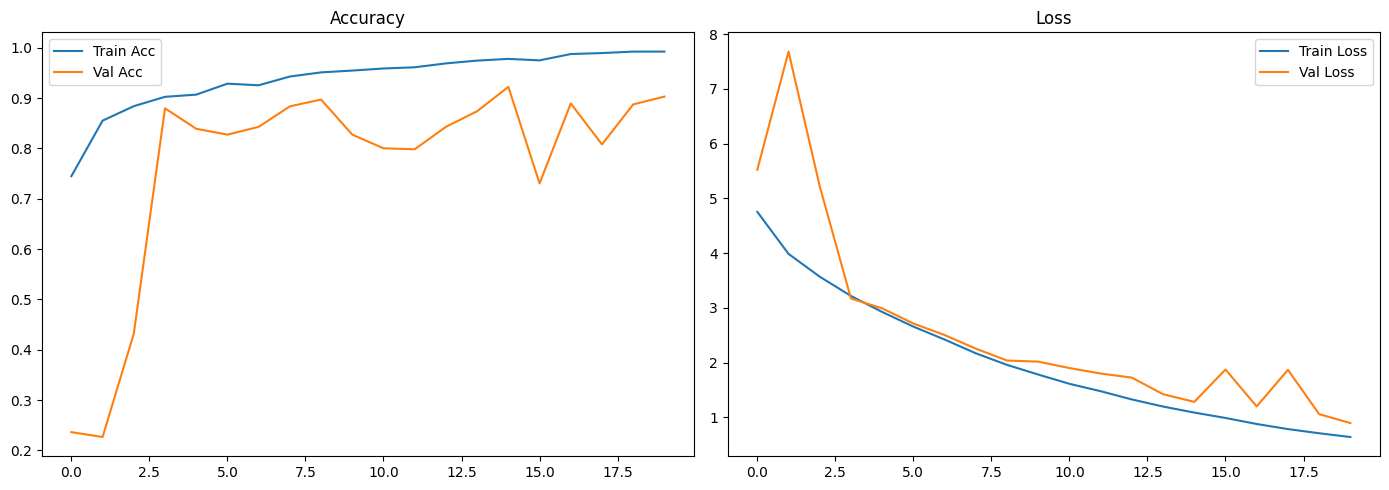

In [8]:
# =============================================================
# 📈 Cell 7 – Plot Accuracy & Loss Curves
# =============================================================
def plot_metrics(hist):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title('Loss'); plt.legend()
    plt.tight_layout(); plt.show()

plot_metrics(history)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step


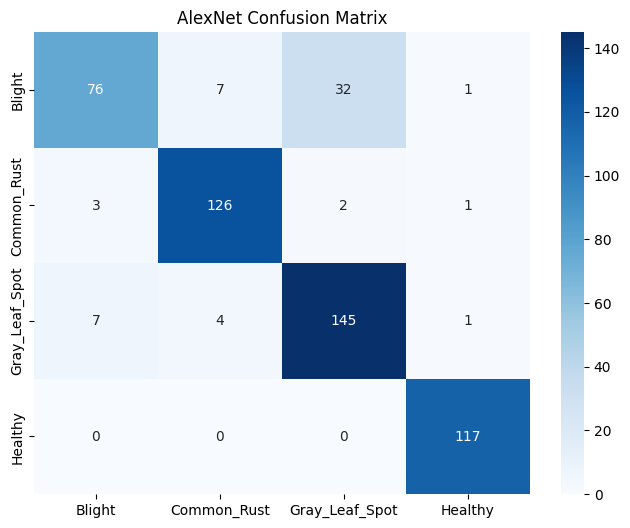

              precision    recall  f1-score   support

           0       0.88      0.66      0.75       116
           1       0.92      0.95      0.94       132
           2       0.81      0.92      0.86       157
           3       0.97      1.00      0.99       117

    accuracy                           0.89       522
   macro avg       0.90      0.88      0.88       522
weighted avg       0.89      0.89      0.89       522



In [11]:
# =============================================================
# 🧮 Cell 8 – Evaluate & Confusion Matrix
# =============================================================
y_pred = alexnet.predict(test_gen)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred_cls)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices,
            yticklabels=test_gen.class_indices)
plt.title('AlexNet Confusion Matrix'); plt.show()

print(classification_report(y_true, y_pred_cls))


In [9]:
# =============================================================
# ✅ Cell 9 – Final Accuracy Numbers
# =============================================================
print(f"Final Training Accuracy   : {history.history['accuracy'][-1]*100:.2f}%")
print(f"Final Validation Accuracy : {history.history['val_accuracy'][-1]*100:.2f}%")
test_loss, test_acc = alexnet.evaluate(test_gen)
print(f"Test Accuracy             : {test_acc*100:.2f}%")


Final Training Accuracy   : 99.25%
Final Validation Accuracy : 90.31%
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.8029 - loss: 1.4275
Test Accuracy             : 88.89%



Class: Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


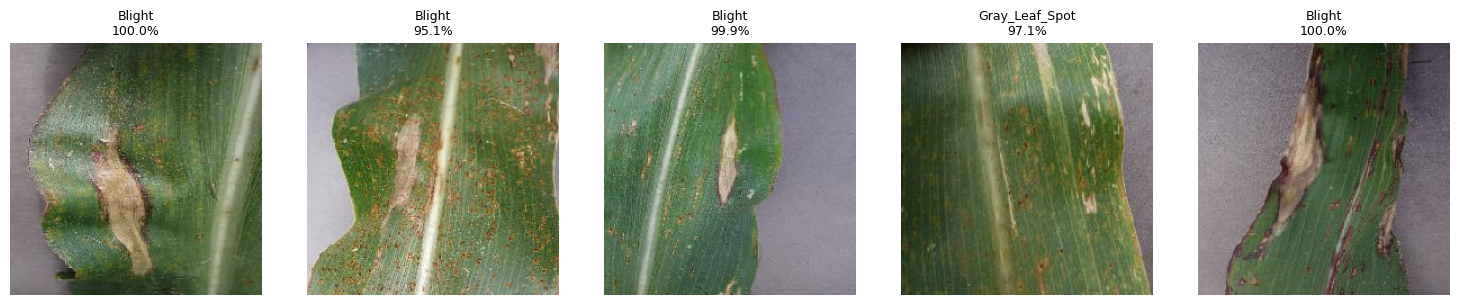


Class: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


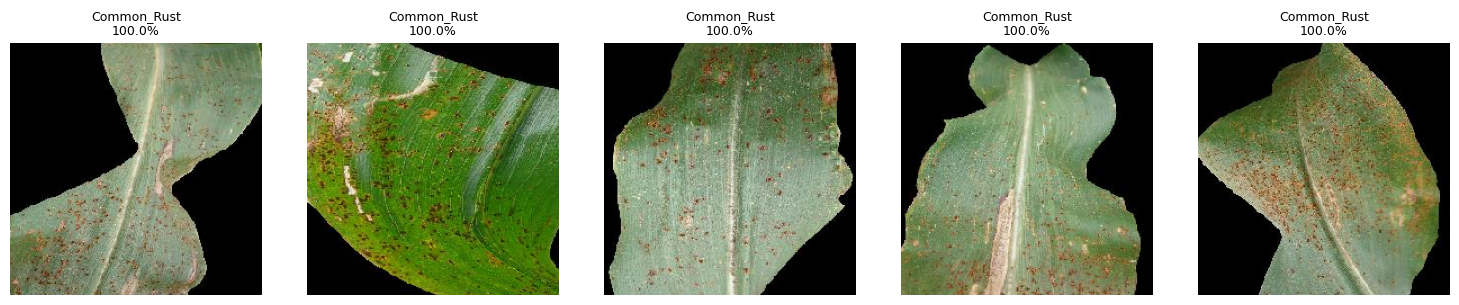


Class: Gray_Leaf_Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


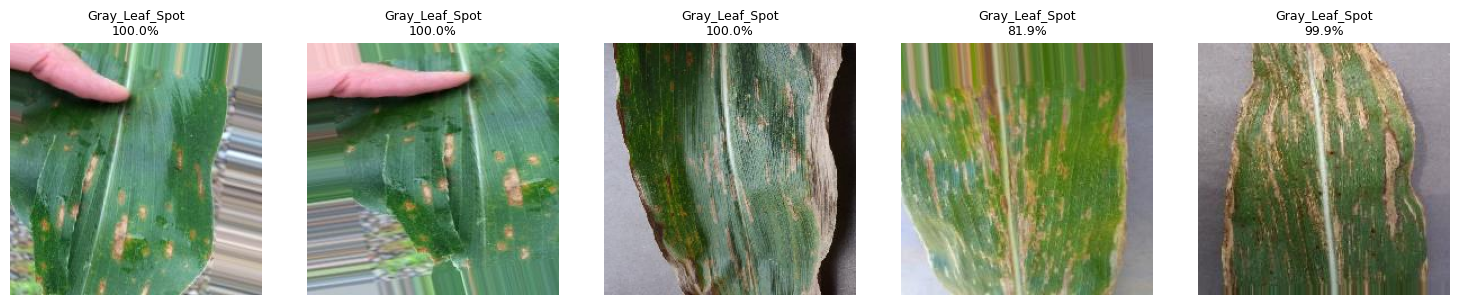


Class: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


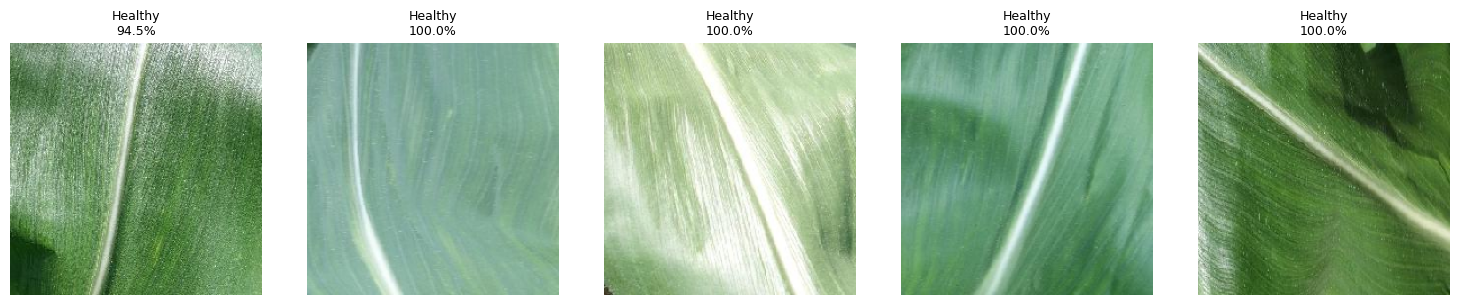

In [12]:
# =============================================================
# 🔍 Cell 10 – Random Predictions on Test Images
# =============================================================
test_dir = os.path.join(base_dir, 'test')
class_names = sorted(os.listdir(test_dir))

for cls in class_names:
    cls_path = os.path.join(test_dir, cls)
    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('jpg','jpeg','png'))]
    sample_imgs = random.sample(imgs, 5)
    print(f"\nClass: {cls}")
    plt.figure(figsize=(15,3))
    for i, img_f in enumerate(sample_imgs):
        img_path = os.path.join(cls_path, img_f)
        img = load_img(img_path, target_size=img_size)
        img_arr = img_to_array(img)/255.0
        pred = alexnet.predict(np.expand_dims(img_arr, axis=0))
        pred_cls = class_names[np.argmax(pred)]
        conf = np.max(pred)*100
        plt.subplot(1,5,i+1)
        plt.imshow(img); plt.axis('off')
        plt.title(f'{pred_cls}\n{conf:.1f}%', fontsize=9)
    plt.tight_layout(); plt.show()
